This file uses both cremad and ravdees dataset


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf

import librosa
import librosa.display
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [8]:
import kagglehub

# Download latest version
path_r = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path_r)

Path to dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1


In [14]:
path_c = kagglehub.dataset_download("ejlok1/cremad")

print("Path to dataset files:", path_c)

Path to dataset files: /root/.cache/kagglehub/datasets/ejlok1/cremad/versions/1


In [15]:
Ravdess = path_r+'/audio_speech_actors_01-24/'
Crema = path_c+'/AudioWAV/'

In [16]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,sad,/root/.cache/kagglehub/datasets/ejlok1/cremad/...
1,angry,/root/.cache/kagglehub/datasets/ejlok1/cremad/...
2,angry,/root/.cache/kagglehub/datasets/ejlok1/cremad/...
3,fear,/root/.cache/kagglehub/datasets/ejlok1/cremad/...
4,disgust,/root/.cache/kagglehub/datasets/ejlok1/cremad/...


In [12]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

<ipython-input-12-9455e7d8fd7d>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)


,Emotions,Path
0,disgust,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...
1,sad,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...
2,sad,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...
3,happy,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...
4,disgust,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...


In [17]:
data_path = pd.concat([Ravdess_df,Crema_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,disgust,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...
1,sad,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...
2,sad,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...
3,happy,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...
4,disgust,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...


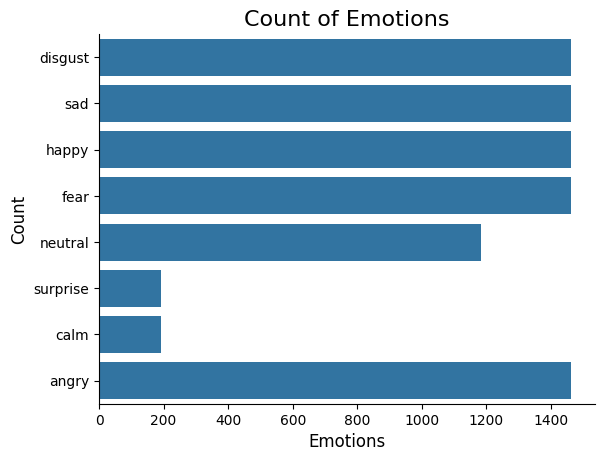

In [18]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [19]:
def create_waveplot(data, sam, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sam)
    plt.show()

def create_spectrogram(data, sam, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sam, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sam, x_axis='time', y_axis='log')
    plt.colorbar()

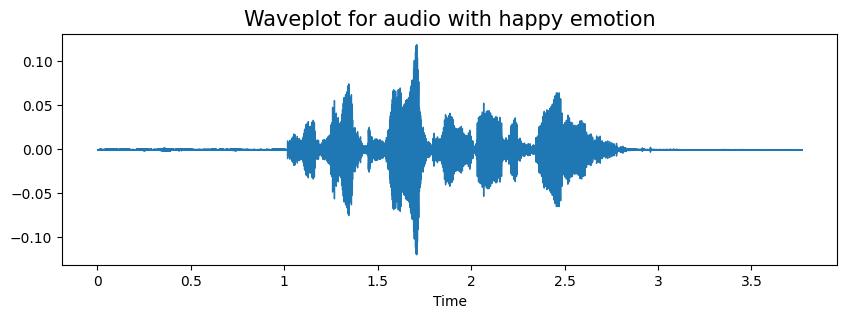

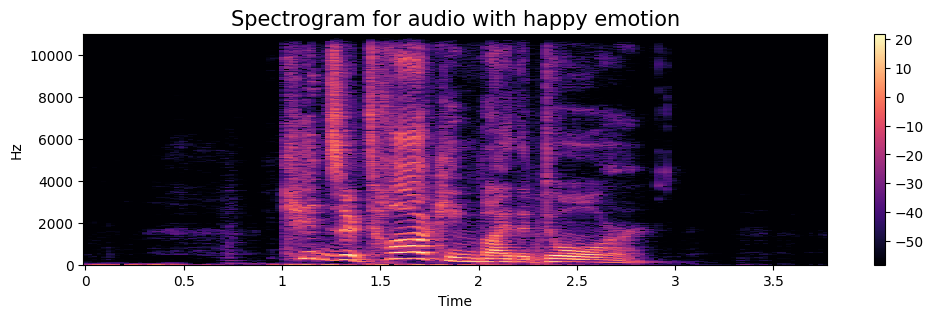

In [20]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[20]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [21]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)




# taking any example and checking for techniques.
path = np.array(data_path.Path)[300]
data, sample_rate = librosa.load(path)

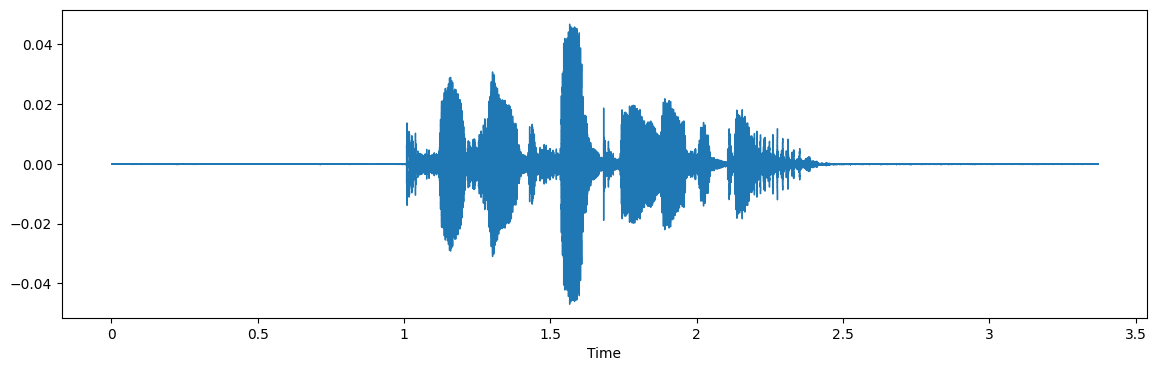

In [22]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

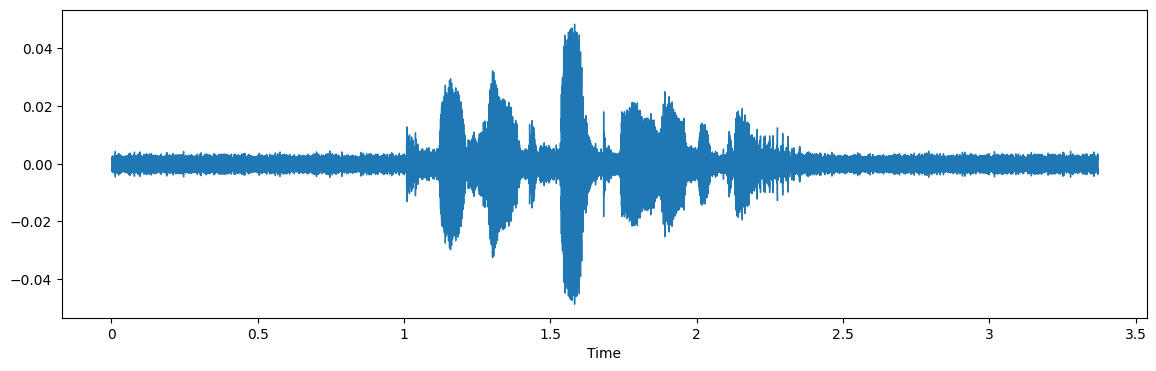

In [23]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

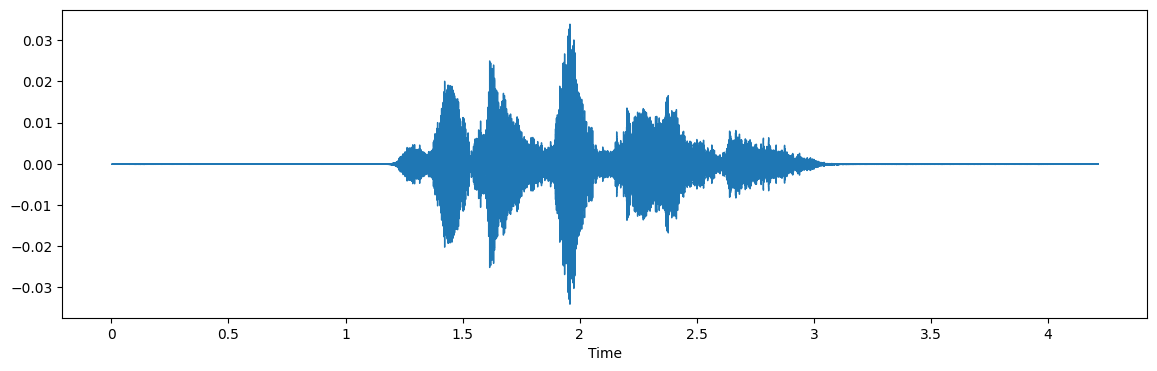

In [24]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

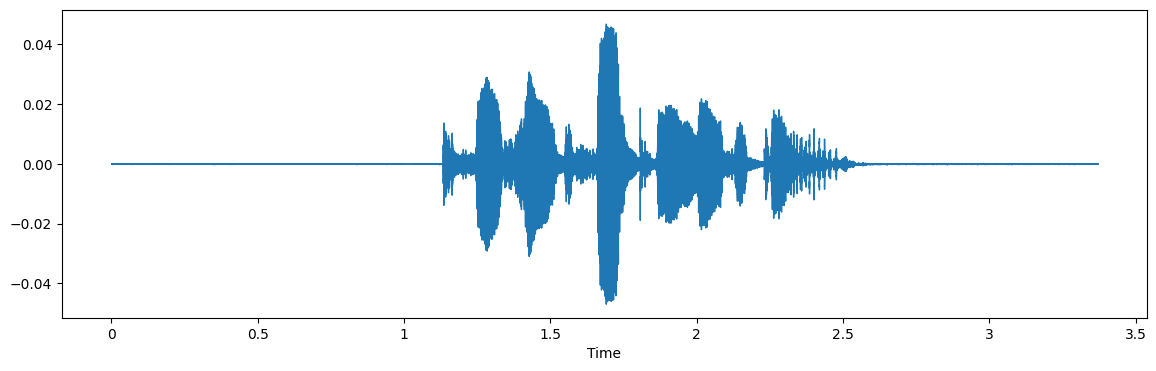

In [25]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [26]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically


    return result

In [27]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 2 times as we have made 2 augmentation techniques on each audio file.
        Y.append(emotion)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [28]:
len(X), len(Y), data_path.Path.shape

(17764, 17764, (8882,))

In [29]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.201760,0.733848,0.752934,0.714460,0.761093,0.667300,0.607998,0.690915,0.726531,0.733534,...,0.000033,0.000031,0.000024,0.000024,0.000023,0.000036,0.000040,0.000021,0.000002,disgust
1,0.311085,0.791306,0.839265,0.816768,0.841658,0.833954,0.724713,0.696447,0.753717,0.756064,...,0.000127,0.000128,0.000117,0.000115,0.000114,0.000122,0.000125,0.000107,0.000095,disgust
2,0.175153,0.541189,0.582987,0.617327,0.725613,0.682995,0.583682,0.544047,0.558316,0.610228,...,0.000139,0.000262,0.000331,0.000276,0.000287,0.000256,0.000264,0.000142,0.000012,sad
3,0.309756,0.695018,0.726540,0.756555,0.824670,0.801163,0.697282,0.648402,0.676058,0.712502,...,0.000931,0.001112,0.001199,0.001079,0.001077,0.001119,0.001122,0.000973,0.000843,sad
4,0.185393,0.684673,0.706716,0.676950,0.683392,0.556231,0.481397,0.540658,0.612390,0.601200,...,0.000049,0.000118,0.000180,0.000149,0.000210,0.000163,0.000130,0.000063,0.000008,sad


In [30]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [31]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [50]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((13323, 162), (13323, 8), (4441, 162), (4441, 8))

In [51]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((13323, 162), (13323, 8), (4441, 162), (4441, 8))

In [52]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((13323, 162, 1), (13323, 8), (4441, 162, 1), (4441, 8))

In [53]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 162, 256)            │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 81, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 81, 256)             │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 41, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 41, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 21, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │          22,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=60, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/60
209/209 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.2405 - loss: 1.8617 - val_accuracy: 0.3450 - val_loss: 1.5978 - learning_rate: 0.0010
Epoch 2/60
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3194 - loss: 1.6392 - val_accuracy: 0.3546 - val_loss: 1.5559 - learning_rate: 0.0010
Epoch 3/60
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3398 - loss: 1.6073 - val_accuracy: 0.3727 - val_loss: 1.5295 - learning_rate: 0.0010
Epoch 4/60
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3508 - loss: 1.5715 - val_accuracy: 0.3817 - val_loss: 1.5021 - learning_rate: 0.0010
Epoch 5/60
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3731 - loss: 1.5366 - val_accuracy: 0.3801 - val_loss: 1.5115 - learning_rate: 0.0010
Epoch 6/60
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3776 - loss: 1.5216 - val_accuracy: 0.4013 - val_loss: 1.4668 - learning_rate: 0.0010
Epoch 7/60
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3940 - loss: 1.5045 

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5157 - loss: 1.4650
Accuracy of our model on test data :  51.137131452560425 %


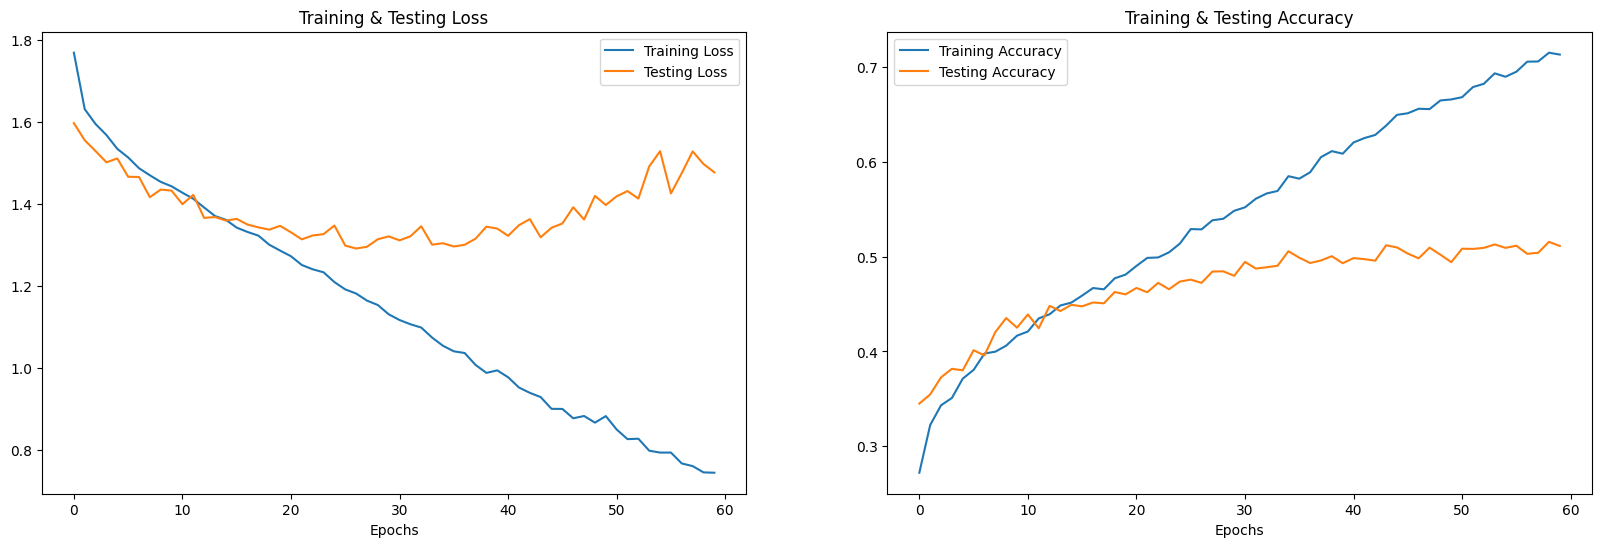

In [55]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(60)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [56]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [58]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,fear
1,neutral,neutral
2,happy,happy
3,calm,calm
4,sad,neutral
5,neutral,neutral
6,disgust,angry
7,disgust,happy
8,neutral,neutral
9,fear,happy


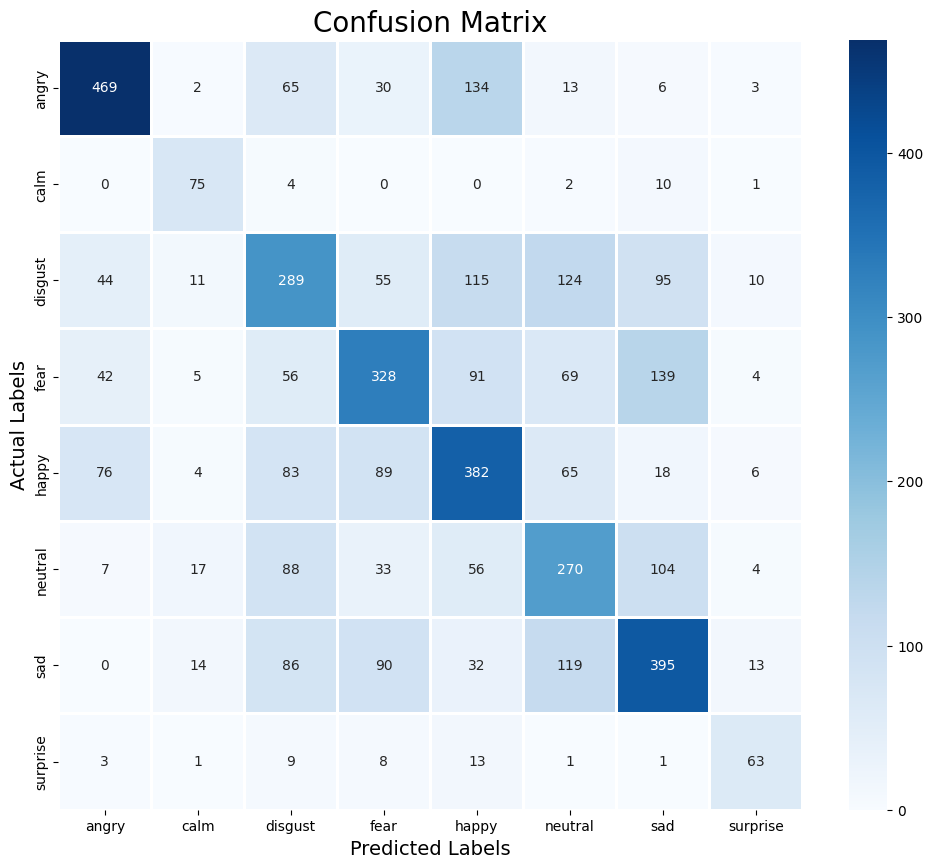

In [59]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.73      0.65      0.69       722
        calm       0.58      0.82      0.68        92
     disgust       0.42      0.39      0.41       743
        fear       0.52      0.45      0.48       734
       happy       0.46      0.53      0.49       723
     neutral       0.41      0.47      0.43       579
         sad       0.51      0.53      0.52       749
    surprise       0.61      0.64      0.62        99

    accuracy                           0.51      4441
   macro avg       0.53      0.56      0.54      4441
weighted avg       0.52      0.51      0.51      4441

